In [2]:
import os
from os import path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
from librosa.core import midi_to_hz, hz_to_midi
import IPython.display as ipd
from magenta.models.nsynth.reader import NSynthDataset

from audio_helpers import plot_spec

%matplotlib inline

In [3]:
!ls /corpora

corrupted		 maps_music_transcription  nsynth	urbansound8k
freesound-audio-tagging  midi_classic_piano	   oxford_pets	voices
gtzan_genre		 million_song_dataset	   sitw		voxceleb
gtzan_music_speech	 mnist			   speech	voxforge
maestro			 music_net		   text		youtube8m


In [4]:
train_record_fn = "/corpora/nsynth/nsynth-train.tfrecord"
assert path.exists(train_record_fn)

In [49]:
# ds = NSynthDataset(train_record_fn, is_training=True)
# batch = ds.get_example(10)

# def random_example():

#     with tf.Session(config=tf.ConfigProto()) as sess:
#         coord = tf.train.Coordinator()
#         threads = tf.train.start_queue_runners(sess=sess, coord=coord)
#         example = sess.run(batch)
#     return example

In [ ]:
filenames = tf.placeholder(tf.string, shape=[None])
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.shuffle(buffer_size=int(2**10))
dataset = dataset.batch(int(2**10))
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()
examples = list()

def decode(serialized_example):
    features = {
        "note_str": tf.FixedLenFeature([], dtype=tf.string),
        "pitch": tf.FixedLenFeature([1], dtype=tf.int64),
        "velocity": tf.FixedLenFeature([1], dtype=tf.int64),
        "audio": tf.FixedLenFeature([64000], dtype=tf.float32),
        "qualities": tf.FixedLenFeature([10], dtype=tf.int64),
        "sample_rate": tf.FixedLenFeature([], dtype=tf.int64),
        "instrument_source": tf.FixedLenFeature([1], dtype=tf.int64),
        "instrument_family": tf.FixedLenFeature([1], dtype=tf.int64),
    }
    return tf.parse_single_example(serialized_example, features)

with tf.Session(config=tf.ConfigProto()) as sess:
    sess.run(iterator.initializer, feed_dict={filenames: [train_record_fn]})
    
    example_tensors = sess.run(next_element)
    examples += [sess.run(decode(example)) for example in example_tensors]

In [ ]:
np.unique([e['note_str'][:4] for e in examples])

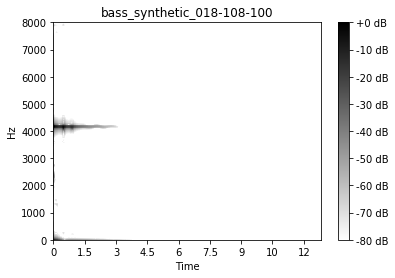

In [15]:
example = np.random.choice(examples)
plot_spec(example['audio'], sr=example['sample_rate'])
plt.title(example['note_str'])
ipd.Audio(example['audio'], rate=example['sample_rate'])

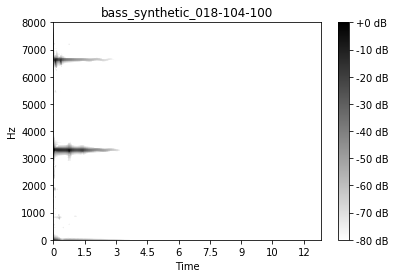

In [11]:
i = 9
plot_spec(examples[i]['audio'], sr=examples[i]['sample_rate'])
plt.title(examples[i]['note_str'])
ipd.Audio(examples[i]['audio'], rate=examples[i]['sample_rate'])

In [73]:
example = random_example()
print(example)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.FailedPreconditionError'>, Attempting to use uninitialized value input_producer_49/limit_epochs/epochs
	 [[Node: input_producer_49/limit_epochs/CountUpTo = CountUpTo[T=DT_INT64, limit=1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](input_producer_49/limit_epochs/epochs)]]
{'instrument_family': array([0]), 'instrument_source': array([2]), 'note_str': 'bass_synthetic_018-100-100', 'qualities': array([0, 0, 1, 1, 0, 0, 0, 1, 0, 0]), 'pitch': array([100]), 'velocity': array([100]), 'audio': array([  1.56525729e-07,  -5.27524264e-07,   1.04732612e-06, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00], dtype=float32)}


In [ ]:
example = random_example()
midi_to_hz(example['pitch']), example['instrument_family']